In [1]:
import sys
import pytest
from pathlib import Path
from collections import defaultdict
from astropy import units as u
from astropy import constants as c
import tabulation
import numpy as np
from scipy import special
import betterplotlib as bpl
bpl.presentation_style()

# add directory of stdout tests to import the parsing
this_dir = Path("").absolute()
sys.path.append(str(this_dir.parent/"stdout_tests"))
from parse_stdout import parse_file

In [2]:
sys.path.append(str(this_dir.parent.parent/"build"))

from snii_enrich_ia_elts_cluster_discrete import lib as snii_c_code
from core_enrich_ia_elts_cluster_discrete import lib as core_c_code

core_c_code.detailed_enrichment_init()
snii_c_code.detailed_enrichment_init()
snii_c_code.init_rand()

In [3]:
base_code_length = u.def_unit("base_code_length", 4 * u.Mpc / 128)
h = 0.6814000010490417
H_0 = 100 * h * u.km / (u.second * u.Mpc)
omega_m = 0.3035999834537506
code_mass = u.def_unit("code_mass", 3 * H_0**2 * omega_m / (8 * np.pi * c.G) *
                       base_code_length**3)
base_code_time = u.def_unit("base_code_time", 2.0 / (H_0 * np.sqrt(omega_m)))
def code_time_func(a_box):
    return u.def_unit("code_time", base_code_time * a_box**2)

def code_length_func(a_box):
    return u.def_unit("code_length", base_code_length * a_box)

def code_energy_func(a_box):
    e_val = code_mass * (code_length_func(a_box) / code_time_func(a_box))**2
    return u.def_unit("code_energy", e_val)

def code_energy_to_erg(energy_in_code_units, a):
    code_energy = code_energy_func(a)
    return (energy_in_code_units * code_energy).to(u.erg).value

def get_sn_mass(step):
    # get the number of supernovae based on the energy
    return 0.5 * (step["m_turnoff_now"] + step["m_turnoff_next"])

def sn_and_hn(step):
    # Determine how many SN and HN are happening in a given timestep. First
    # we'll use the IMF limits to estimate how many SN are possible in this
    # timestep. then we'll test all possible combinations of SN and HN in this
    # timestep to see if they match the energy injected
    energy_ergs = code_energy_to_erg(step["energy added"], step["abox[level]"])
    sn_mass = get_sn_mass(step)
    total_sn = int(step["number SN"])

    if sn_mass < 20.0:  # no HN
        n_sn = int(round(energy_ergs / 1E51, 0))
        return n_sn, 0
    else:
        hn_energy = snii_c_code.hn_energy_py(sn_mass)
        for n_hn in range(total_sn + 1): # have iteration with all HN
            n_sn = total_sn - n_hn
            this_E = n_sn * 1E51 + n_hn * hn_energy
            if this_E == pytest.approx(energy_ergs, abs=0, rel=1E-4):
                return n_sn, n_hn
        # if we got here we didn't find an answer
        assert False

In [4]:
stdout_file = str(this_dir.parent/"stdout_tests/stdout_snii.txt")
timesteps_all = parse_file(stdout_file, "SNII")

In [5]:
len(timesteps_all)

12173

In [6]:
# then go through them and pick the ones with HN
timesteps_hn = []

for timestep in timesteps_all:
    if timestep["energy added"] > 0 and timestep["m_turnoff_now"] > 20:
        timesteps_hn.append(timestep)

In [7]:
len(timesteps_hn)

192

# Check metallicities

In [8]:
zs = [step["metallicity"] for step in timesteps_hn]

In [9]:
min(zs)

9.885516192298383e-06

In [10]:
max(zs) 

0.0006737691001035273

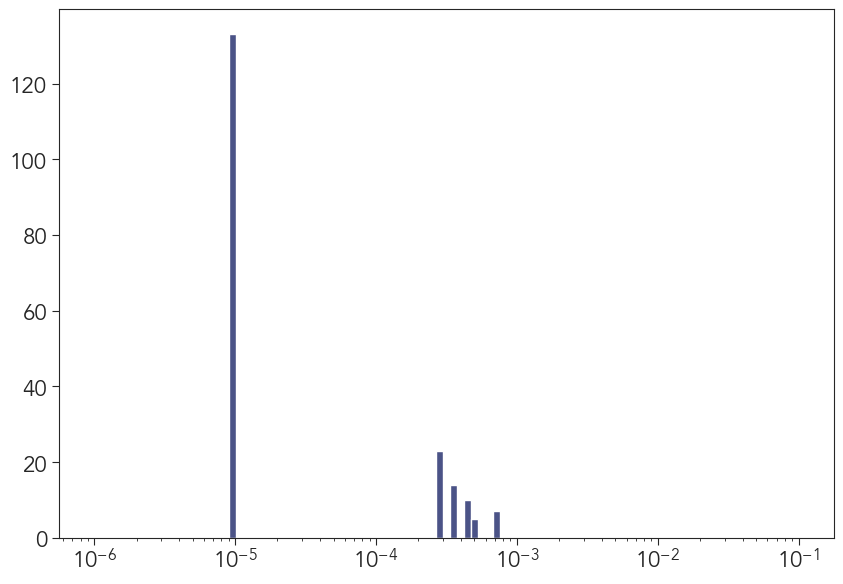

In [11]:
fig, ax = bpl.subplots()

bin_edges = np.logspace(-6, -1, 100)
ax.hist(zs, bins=bin_edges)
ax.set_xscale("log")

In [12]:
def find_bin(z):
    return str(round(np.log10(z/0.02), 1))

binned_steps = defaultdict(list)
for step in timesteps_hn:
    binned_steps[find_bin(step["metallicity"])].append(step)

In [13]:
for item in binned_steps:
    print(len(binned_steps[item]))

133
23
14
15
7


In [14]:
binned_zs   = []
binned_f_hn = []
binned_f_hn_error = []

for z in binned_steps:
    binned_zs.append(float(z))
    
    n_sn = 0
    n_hn = 0
    for step in binned_steps[z]:
        s, h = sn_and_hn(step)
        n_sn += s
        n_hn += h
    
    n_tot = n_hn + n_sn
    print(z, n_tot)
    this_f = n_hn / n_tot
    binned_f_hn.append(this_f)
    # https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Normal_approximation_interval
    binned_f_hn_error.append(np.sqrt(this_f * (1 - this_f) / n_tot))

-3.3 133
-1.9 23
-1.7 14
-1.6 15
-1.5 7


Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


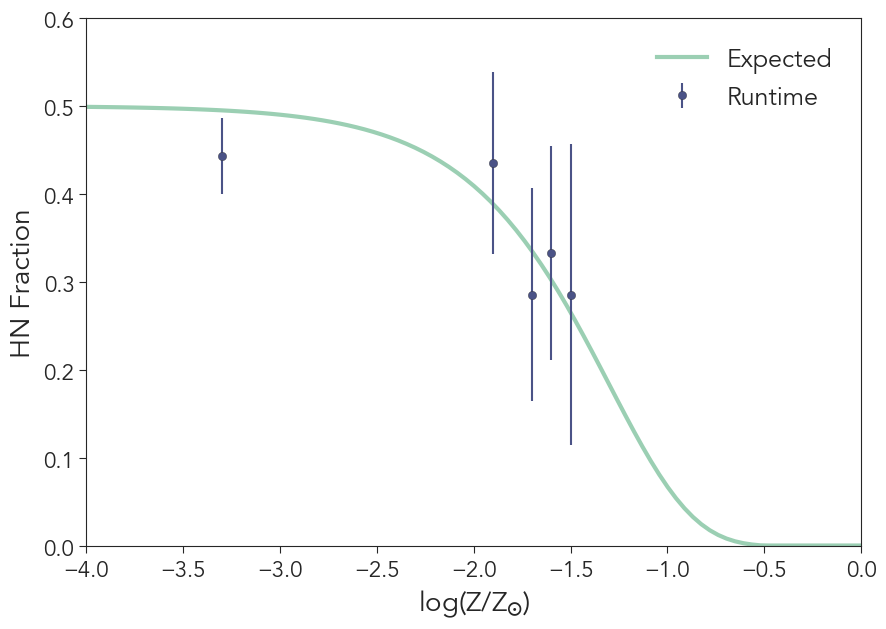

In [15]:
fig, ax = bpl.subplots()\

ax.errorbar(binned_zs, binned_f_hn, yerr=binned_f_hn_error, label="Runtime", zorder=10)

z_raw = np.logspace(-6, np.log10(0.02), 100)
z_plot = np.log10(z_raw / 0.02)
hn_fraction = [snii_c_code.get_hn_fraction_py(z) for z in z_raw]
ax.plot(z_plot, hn_fraction, label="Expected")

ax.add_labels("log(Z/$Z_{\odot}$)", "HN Fraction")
ax.set_limits(-4, 0, 0, 0.6)
ax.legend()
fig.savefig("stdout_hn_fraction.png", bbox_inches="tight")